<a href="https://www.kaggle.com/code/lorenzoarcioni/collaborative-latent-factors-recommending-system?scriptVersionId=218934154" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

 # Collaborative Latent-Factors-Based Filtering for Movie Recommendations (Incomplete)

## Introduction

The latent factor approach in recommendation systems utilizes matrix factorization techniques to uncover hidden patterns in user-item interactions. These methods predict user preferences by mapping both users and items to a shared latent space where their interactions can be represented by their proximity or alignment. Latent factor models, such as Singular Value Decomposition (SVD), are widely used in this context.

Key features of the latent factor approach:
- Captures underlying relationships between users and items.
- Handles sparse datasets effectively by reducing dimensionality.
- Improves scalability compared to neighborhood-based methods.

In this notebook, we will explore the latent factor approach to build a movie recommendation system using matrix factorization.

### Mathematical Background

The latent factor approach works by:
- Represent users and items in a shared lower dimensional latent space (i.e., as a vector of latent factors).
- Such vectros are inferred (i.e., learned) from the observed ratings.
- High correlation between user and item latent factors indicates a possible recomendation.
- Map both users and items to the latent space and then predict ratings based on the inner product in the latent space.

So formally we have:
- $R = \{0, 1, \dots, 5\} \lor R = [0, 1]$ is the set of ratings.
- $\vec x_u \in R^d$ is the latent factor vector for user $u$. Each $\vec x_u[k] \in R$ measure the extent of interest user $u$ has in items exhibiting latent factor $k$.
- $\vec w_i \in R^d$ is the latent factor vector for item $i$. Each $\vec w_i[k] \in R$ measure the extent of interest item $i$ has in users exhibiting latent factor $k$.

Essentially, $d$ hidden features to describe both users and items.

Thus, $r_{u,i}$ is the rating given by user $u$ to item $i$ and $\hat{r}_{u,i} = \vec x_u \cdot \vec w_i = \sum_{k=1}^d \vec x_u[k] \cdot \vec w_i[k]$ is the predicted rating for user $u$ and item $i$.

The problem is to approximate the user-item matrix $M \in \mathbb R^{n \times m}$ with the product of a user latent factor matrix $X \in \mathbb R^{n \times d}$ and an item latent factor matrix $W^T \in \mathbb R^{d \times m}$. So

$$
M \approx X \cdot W^T.
$$

## Dataset Description

We use two datasets for this analysis:

1. **Movies Dataset**:
   - `Movie_ID`: Unique identifier for each movie.
   - `Title`: Name of the movie.
   - `Year`: Year the movie was released.

2. **Ratings Dataset**:
   - `User_ID`: Unique identifier for each user.
   - `Movie_ID`: Identifier for the movie rated by the user.
   - `Rating`: Numeric rating provided by the user (e.g., on a scale of 1-5).

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# Load the datasets
movies_file = "/kaggle/input/netflix-movie-rating-dataset/Netflix_Dataset_Movie.csv"
ratings_file = "/kaggle/input/netflix-movie-rating-dataset/Netflix_Dataset_Rating.csv"

ratings = pd.read_csv(ratings_file)  # Columns: User_ID, Rating, Movie_ID
movies  = pd.read_csv(movies_file)    # Columns: Movie_ID, Year, Name

### Formal Definition

- $U = \{u_1, u_2, \dots, u_n\}$ is the set of users.
- $U_i = \{u \in U \mid r_{u,i} \neq 0\}$ is the set of users who have rated item $i$
- $I = \{i_1, i_2, \dots, i_m\}$ is the set of items.
- $I_u = \{i \in I \mid r_{u,i} \neq 0\}$ is the set of items rated by user $u$
- $R = \{0, 1, \dots, 5\} \lor R = [0, 1]$ is the set of ratings.
- $r_{u,i}$ is the rating given by user $u$ for item $i$ (equal to 0 if not rated).
- $D = \{(u_j, i_j)\}_{j=1}^{N}$ is the set of user-item pairs (our dataset).
- $I_D = \{i \in I \mid \exists (u, i) \in D\}$ is the set of items in the dataset.
- $U_D = \{u \in U \mid \exists (u, i) \in D\}$ is the set of users in the dataset.

## User-Based Collaborative Filtering

### 1. Data Preprocessing
- **User-Item Matrix Creation**: Convert the ratings dataset into a user-item matrix, where rows represent users and columns represent movies. Missing ratings are filled with zeros. Each rating is represented by a number from 1 to 5.
  $$ M[u, i] = r_{u,i} \in R$$
  Where:
  - $u \in U$
  - $i \in I$
  - $r_{u,i}$ is the rating given by user $u$ for movie $i$.

- **Sparse Matrix Conversion**: The dense matrix is converted to a sparse format for memory optimization:
  $$M_{\{\text{sparse}\}} = \text{sparse}(M)$$

In [2]:
# Step 1: Create a user-item matrix
user_item_matrix = ratings.pivot(index='User_ID', columns='Movie_ID', values='Rating')

# Fill missing values with 0 (can use NaN for some algorithms)
user_item_matrix.fillna(0, inplace=True) # It is not the case for this dataset

# Convert the DataFrame to a sparse matrix
sparse_user_item = csr_matrix(user_item_matrix.values)

### 2. Determine the Loss Function and Computing Its Gradient

Assuming we have access to the dataset $D$ of observed ratings, the matrix $M$ is partially known and filled with those observations. To actually learn the latent factors, we need to choose a loss function to optimize. In our case, we choose squared error (SE):

$$
L(X, W) = \frac{1}{2} \left[ \sum_{(u, i) \in D} (r_{u,i} - \hat{r}_{u,i})^2 + \lambda (\sum_{u \in U_D} \|\vec x_u\|^2 + \sum_{i \in I_D} \|\vec w_i\|^2)\right]
$$

Thus, 

$$X^*, W^* = \argmin_{X, W} \ L(X, W).$$

#### Loss Function
The loss function in matrix notation is defined in terms of matrices as:
$$
L(X, W) = \frac{1}{2} \left[ \| M - X W^T \|_F^2 + \lambda \left( \|X\|_F^2 + \|W\|_F^2 \right) \right],
$$
where:
- $M \in \mathbb{R}^{n \times m}$ is the observed rating matrix, with $M_{u,i} = r_{u,i}$ if user $u$ has rated item $i$, and 0 otherwise.
- $X \in \mathbb{R}^{n \times d}$ represents the user latent factors (each row corresponds to a user vector $X_u$).
- $W \in \mathbb{R}^{m \times d}$ represents the item latent factors (each row corresponds to an item vector $W_i$).
- $\| \cdot \|_F$ is the Frobenius norm.

The prediction matrix is:
$$
\hat{M} = X W^T.
$$

The loss consists of:
1. The reconstruction error:
$$
\| M - X W^T \|_F^2 = \sum_{(u, i) \in D} (r_{u,i} - X_u W_i^T)^2.
$$
2. The regularization terms:
$$
\lambda \left( \|X\|_F^2 + \|W\|_F^2 \right).
$$

---

#### Computing the Gradients

##### Gradient with respect to $X$

1. Differentiate the reconstruction error term:
$$
\frac{\partial}{\partial X} \frac{1}{2} \| M - X W^T \|_F^2 = -(M - X W^T) W.
$$

2. Differentiate the regularization term:
$$
\frac{\partial}{\partial X} \frac{\lambda}{2} \|X\|_F^2 = \lambda X.
$$

3. Combine the two terms:
$$
\frac{\partial L}{\partial X} = -(M - X W^T) W + \lambda X.
$$

---

##### Gradient with respect to $W$

1. Differentiate the reconstruction error term:
$$
\frac{\partial}{\partial W} \frac{1}{2} \| M - X W^T \|_F^2 = -(M - X W^T)^T X.
$$

2. Differentiate the regularization term:
$$
\frac{\partial}{\partial W} \frac{\lambda}{2} \|W\|_F^2 = \lambda W.
$$

3. Combine the two terms:
$$
\frac{\partial L}{\partial W} = -(M - X W^T)^T X + \lambda W.
$$

In [3]:
# Step 2: Creating the matrix M

# Dimensions of the user-item matrix
num_users, num_items = user_item_matrix.shape

# Create a mask for observed entries in R
M = user_item_matrix.values 
mask = M > 0  # Boolean mask for observed entries

### 3. Optimize the Loss Function with Stochastic Gradient Descent

In order to optimize the loss function, we use Stochastic Gradient Descent (SGD).

#### Explanation of the SGD Algorithm (Matrix Form)

##### 1. Initialization
- Matrices $X$ (users' latent factors) and $W$ (items' latent factors) are initialized randomly with small values.
- $X \in \mathbb{R}^{m \times d}$, where $m$ is the number of users and $d$ is the number of latent factors.
- $W \in \mathbb{R}^{n \times d}$, where $n$ is the number of items.

##### 2. Gradient Computation
- Define the prediction matrix:
  $$
  \hat{M} = X W^T
  $$
- Compute the error matrix (only for observed entries in $M$):
  $$
  E = \begin{cases}
  M_{ui} - \hat{M}_{ui} \quad &\text{if} \ M_{ui} > 0\\
  0 \quad &\text{otherwise}
  \end{cases},
  $$
  where $E_{ui} = 0$ for unobserved entries of $M$.

- Gradients for $X$ and $W$:
  $$
  \nabla_X = - E W + \lambda X
  $$
  $$
  \nabla_W = - E^T X + \lambda W
  $$

##### 3. Updates
- Update the latent factor matrices $X$ and $W$ simultaneously:
  $$
  X \leftarrow X - \eta \nabla_X
  $$
  $$
  W \leftarrow W - \eta \nabla_W
  $$
- Here, $\eta$ is the learning rate.

##### 4. Loss Tracking
- The total loss for each epoch combines the squared error and the regularization terms:
  $$
  L = \| M - X W^T \|_F^2 + \lambda (\|X\|_F^2 + \|W\|_F^2)
  $$
- This tracks the reconstruction error and ensures that the latent factor matrices do not grow too large (controlled by the regularization term).

##### 5. Optimization Loop
- Repeat the following steps for a fixed number of epochs or until the loss converges:
  1. Compute the error matrix $E$.
  2. Compute the gradients $\nabla_X$ and $\nabla_W$ using matrix operations.
  3. Update $X$ and $W$ using the gradients.
  4. Track and print the loss for each epoch.

---

##### Notes
- This implementation only updates $X$ and $W$ for the observed entries of $M$ using matrix masking.
- The hyperparameters ($\eta$, $d$, and $\lambda$) should be tuned based on the dataset for optimal performance.

In [4]:
!pip install tqdm_joblib

In [5]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib  # Per gestire le barre di avanzamento con joblib

# Set the numpy seed
np.random.seed(42)

# Hyperparameters
num_factors = 300  # Number of latent factors (k)
reg_lambda = 0.0001  # Regularization term (lambda)
gradient_clip = 10.0  # Gradient clipping threshold
num_epochs = 15 # Number of epochs
learning_rate = 0.001 # Learning rate (eta)

# Initialize X and W with small random values
X = 0.1 * np.random.randn(num_users, num_factors)
W = 0.1 * np.random.randn(num_items, num_factors)

# Loss history
loss_history = []

# Function to compute gradients for a single user (for X) or item (for W)
def compute_gradient_X(u):
    rated_items = mask[u, :]  # Mask for items rated by user u
    W_rated = W[rated_items]  # Subset of W for rated items
    M_rated = M[u, rated_items]  # Subset of M for rated items

    # Compute error and gradient for user u
    E_u = M_rated - X[u, :] @ W_rated.T
    grad = -E_u @ W_rated + reg_lambda * X[u, :]
    return np.clip(grad, -gradient_clip, gradient_clip)

def compute_gradient_W(i):
    rated_users = mask[:, i]  # Mask for users who rated item i
    X_rated = X[rated_users]  # Subset of X for rated users
    M_rated = M[rated_users, i]  # Subset of M for rated users

    # Compute error and gradient for item i
    E_i = M_rated - X_rated @ W[i, :].T
    grad = -E_i.T @ X_rated + reg_lambda * W[i, :]
    return np.clip(grad, -gradient_clip, gradient_clip)

# SGD Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Compute the predicted matrix
    M_hat = X @ W.T

    # Compute the error matrix for observed entries only
    E = np.multiply(mask, M - M_hat)

    # Parallel computation of gradients with progress bars
    grad_X = np.zeros_like(X)
    grad_W = np.zeros_like(W)

    # Update X with a shared progress bar
    print("  Gradient wrt X...")
    with tqdm_joblib(tqdm(desc="    Users", total=num_users, leave=True, disable=True)) as _:
        grad_X = np.array(
            Parallel(n_jobs=-1)(delayed(compute_gradient_X)(u) for u in range(num_users))
        )

    # Update W with a shared progress bar
    print("  Gradient wrt W...")
    with tqdm_joblib(tqdm(desc="    Items", total=num_items, leave=True, disable=True)) as _:
        grad_W = np.array(
            Parallel(n_jobs=-1)(delayed(compute_gradient_W)(i) for i in range(num_items))
        )

    # Apply updates
    X -= learning_rate * grad_X
    W -= learning_rate * grad_W

    # Compute the total loss
    reconstruction_loss = np.sum(np.multiply(mask, E) ** 2)
    regularization_loss = reg_lambda * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(W, 'fro') ** 2)
    total_loss = reconstruction_loss + regularization_loss

    # Append the total loss to the history
    loss_history.append(total_loss)

    # Print the loss for the current epoch
    print(f"  Reconstruction Loss: {reconstruction_loss:.4f}")
    print(f"  Regularization Loss: {regularization_loss:.4f}")
    print(f"  Total Loss: {total_loss:.4f}")

    # Debugging: Check mean and std of gradients
    print(f"  Gradient X: mean={np.mean(grad_X):.4f}, std={np.std(grad_X):.4f}")
    print(f"  Gradient W: mean={np.mean(grad_W):.4f}, std={np.std(grad_W):.4f}")

# Salvataggio delle matrici X e W in formato .npy
np.save("X_matrix_sgd.npy", X)
np.save("W_matrix_sgd.npy", W)

/usr/local/lib/python3.10/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Epoch 1/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 243626310.1290
  Regularization Loss: 43.4087
  Total Loss: 243626353.5377
  Gradient X: mean=0.0758, std=4.0526
  Gradient W: mean=-0.1474, std=8.9375
Epoch 2/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 242017837.6996
  Regularization Loss: 43.5454
  Total Loss: 242017881.2449
  Gradient X: mean=0.0340, std=4.1079
  Gradient W: mean=0.2900, std=9.4772
Epoch 3/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 238911056.2023
  Regularization Loss: 44.0098
  Total Loss: 238911100.2121
  Gradient X: mean=0.1411, std=6.0012
  Gradient W: mean=0.3317, std=9.7081
Epoch 4/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 231730015.0275
  Regularization Loss: 44.9669
  Total Loss: 231730059.9944
  Gradient X: mean=0.2108, std=7.4743
  Gradient W: mean=0.2084, std=9.9048
Epoch 5/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 219051130.1372
  Regularization Loss: 46.5573
  Total Loss: 219051176.6946
  Gradient X: mean=0.2148, std=8.4622
  Gradient W: mean=0.2093, std=9.9569
Epoch 6/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 200657239.4182
  Regularization Loss: 48.8725
  Total Loss: 200657288.2908
  Gradient X: mean=0.2222, std=9.0626
  Gradient W: mean=0.2196, std=9.9777
Epoch 7/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 177157840.8773
  Regularization Loss: 51.9655
  Total Loss: 177157892.8428
  Gradient X: mean=0.2250, std=9.4108
  Gradient W: mean=0.2318, std=9.9867
Epoch 8/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 149736506.3897
  Regularization Loss: 55.8644
  Total Loss: 149736562.2541
  Gradient X: mean=0.2240, std=9.6016
  Gradient W: mean=0.2323, std=9.9905
Epoch 9/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 120039137.7489
  Regularization Loss: 60.5811
  Total Loss: 120039198.3300
  Gradient X: mean=0.2209, std=9.6947
  Gradient W: mean=0.2286, std=9.9925
Epoch 10/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 90116129.1681
  Regularization Loss: 66.1091
  Total Loss: 90116195.2772
  Gradient X: mean=0.2174, std=9.7132
  Gradient W: mean=0.2218, std=9.9941
Epoch 11/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 62398519.9918
  Regularization Loss: 72.3800
  Total Loss: 62398592.3719
  Gradient X: mean=0.2134, std=9.6100
  Gradient W: mean=0.2168, std=9.9916
Epoch 12/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 39683761.9026
  Regularization Loss: 78.8950
  Total Loss: 39683840.7976
  Gradient X: mean=0.2009, std=9.0203
  Gradient W: mean=0.2093, std=9.9725
Epoch 13/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 24844793.8614
  Regularization Loss: 83.5478
  Total Loss: 24844877.4093
  Gradient X: mean=0.1371, std=7.0183
  Gradient W: mean=0.1445, std=9.9118
Epoch 14/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 18079698.1126
  Regularization Loss: 84.9301
  Total Loss: 18079783.0427
  Gradient X: mean=0.0388, std=4.6239
  Gradient W: mean=0.0618, std=9.7455
Epoch 15/15
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 15431366.1285
  Regularization Loss: 85.8231
  Total Loss: 15431451.9515
  Gradient X: mean=0.0267, std=2.7725
  Gradient W: mean=0.0760, std=9.7207


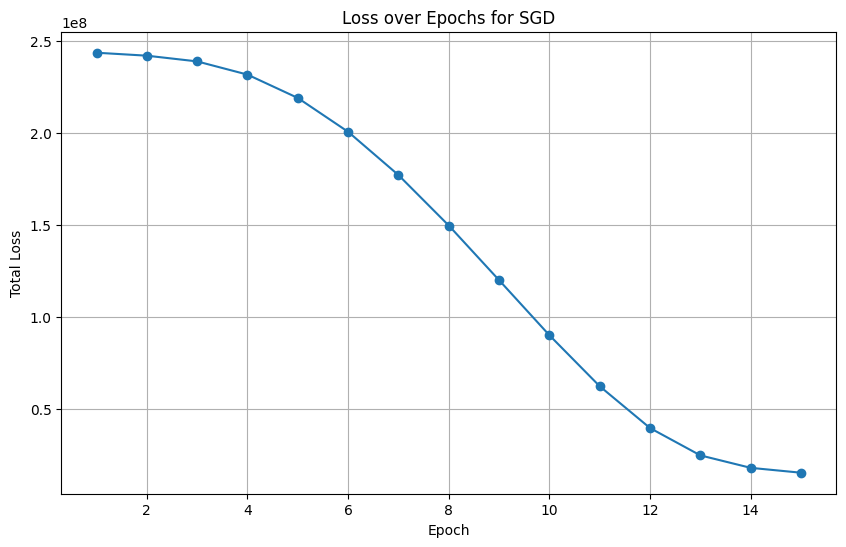

In [6]:
from matplotlib import pyplot as plt

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Loss over Epochs for SGD')
plt.grid()
plt.show()

### Optimize the Loss Function with Alternating Least Squares (ALS)

Alternating Least Squares (ALS) is an optimization method for matrix factorization that alternates between updating the user latent factors ($X$) and the item latent factors ($W$).

#### Objective
The goal is to minimize the following loss function:
$$
L(X, W) = \|M - XW^T\|_F^2 + \lambda (\|X\|_F^2 + \|W\|_F^2)
$$
Where:
- $M$: User-item interaction matrix.
- $X$: User latent factor matrix ($m \times k$).
- $W$: Item latent factor matrix ($n \times k$).
- $\lambda$: Regularization parameter.

#### ALS Algorithm
1. **Initialization**:
   - Start with random values for $X$ and $W$.
2. **Alternating Updates**:
   - Fix $W$, solve for $X$:
     $$
     X_u = (W^T W + \lambda I)^{-1} W^T M_u
     $$
   - Fix $X$, solve for $W$:
     $$
     W_i = (X^T X + \lambda I)^{-1} X^T M_i
     $$
3. **Convergence**:
   - Iterate until the loss stabilizes or a set number of epochs is reached.

In [7]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib  # Progress bars synchronized with joblib

# Set the numpy seed
np.random.seed(42)

# Hyperparameters
num_factors = 300  # Number of latent factors (k)
reg_lambda = 0.0001  # Regularization term (lambda)
num_epochs = 100 # Number of epochs

# Initialize X and W with small random values
X = np.random.normal(scale=0.01, size=(num_users, num_factors))
W = np.random.normal(scale=0.01, size=(num_items, num_factors))

# List to store the loss values for each iteration
loss_history = []

def update_user(u, W, M, mask, reg_lambda, num_factors):
    """Update a single user's latent factors."""
    rated_items = mask[u, :]  # Mask for items rated by user u
    W_rated = W[rated_items, :]
    M_rated = M[u, rated_items]
    
    A = W_rated.T @ W_rated + reg_lambda * np.eye(num_factors)
    b = W_rated.T @ M_rated
    return np.linalg.solve(A, b)

def update_item(i, X, M, mask, reg_lambda, num_factors):
    """Update a single item's latent factors."""
    rated_users = mask[:, i]  # Mask for users who rated item i
    X_rated = X[rated_users, :]
    M_rated = M[rated_users, i]
    
    A = X_rated.T @ X_rated + reg_lambda * np.eye(num_factors)
    b = X_rated.T @ M_rated
    return np.linalg.solve(A, b)

# ALS iterations
for iteration in range(num_epochs):
    print(f"Iteration {iteration + 1}/{num_epochs}")
    
    # Update X by fixing W (Parallelized) with synchronized progress bar
    print("  Updating X...")
    with tqdm_joblib(tqdm(desc="    Users", total=num_users, leave=True, disable=True)) as _:
        X = np.array(Parallel(n_jobs=-1)(
            delayed(update_user)(u, W, M, mask, reg_lambda, num_factors) for u in range(num_users)
        ))
    
    # Update W by fixing X (Parallelized) with synchronized progress bar
    print("  Updating W...")
    with tqdm_joblib(tqdm(desc="    Items", total=num_items, leave=True, disable=True)) as _:
        W = np.array(Parallel(n_jobs=-1)(
            delayed(update_item)(i, X, M, mask, reg_lambda, num_factors) for i in range(num_items)
        ))
    
    # Compute the loss
    M_hat = X @ W.T
    reconstruction_loss = np.sum(np.multiply(mask, (M - M_hat) ** 2))
    regularization_loss = reg_lambda * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(W, 'fro') ** 2)
    total_loss = reconstruction_loss + regularization_loss
    
    # Save the loss in history
    loss_history.append(total_loss)
    
    # Print loss for the current iteration
    print(f"  Reconstruction Loss: {reconstruction_loss:.4f}")
    print(f"  Regularization Loss: {regularization_loss:.4f}")
    print(f"  Total Loss: {total_loss:.4f}")

# Salvataggio delle matrici X e W in formato .npy
np.save("X_matrix_als.npy", X)
np.save("W_matrix_als.npy", W)

Iteration 1/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 3379556.0213
  Regularization Loss: 1802024.6028
  Total Loss: 5181580.6241
Iteration 2/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 976290.2508
  Regularization Loss: 1267848.5384
  Total Loss: 2244138.7893
Iteration 3/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 573158.9917
  Regularization Loss: 1144346.9560
  Total Loss: 1717505.9477
Iteration 4/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 429675.9428
  Regularization Loss: 1088459.1872
  Total Loss: 1518135.1299
Iteration 5/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 357391.7216
  Regularization Loss: 1051509.5056
  Total Loss: 1408901.2272
Iteration 6/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 313763.7939
  Regularization Loss: 1023132.6121
  Total Loss: 1336896.4059
Iteration 7/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 284140.9997
  Regularization Loss: 999527.3862
  Total Loss: 1283668.3859
Iteration 8/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 262284.6827
  Regularization Loss: 978932.9977
  Total Loss: 1241217.6804
Iteration 9/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 245175.7599
  Regularization Loss: 960430.1591
  Total Loss: 1205605.9191
Iteration 10/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 231207.6747
  Regularization Loss: 943492.4151
  Total Loss: 1174700.0897
Iteration 11/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 219456.6634
  Regularization Loss: 927793.4639
  Total Loss: 1147250.1273
Iteration 12/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 209354.0784
  Regularization Loss: 913116.5803
  Total Loss: 1122470.6586
Iteration 13/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 200527.6297
  Regularization Loss: 899308.9781
  Total Loss: 1099836.6078
Iteration 14/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 192719.9877
  Regularization Loss: 886257.3945
  Total Loss: 1078977.3822
Iteration 15/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 185745.0090
  Regularization Loss: 873874.2857
  Total Loss: 1059619.2946
Iteration 16/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 179463.0461
  Regularization Loss: 862089.6341
  Total Loss: 1041552.6802
Iteration 17/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 173766.2913
  Regularization Loss: 850845.8755
  Total Loss: 1024612.1667
Iteration 18/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 168569.6125
  Regularization Loss: 840094.6371
  Total Loss: 1008664.2495
Iteration 19/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 163804.5466
  Regularization Loss: 829794.5621
  Total Loss: 993599.1087
Iteration 20/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 159415.2015
  Regularization Loss: 819909.8047
  Total Loss: 979325.0062
Iteration 21/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 155355.3665
  Regularization Loss: 810408.9529
  Total Loss: 965764.3194
Iteration 22/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 151586.4205
  Regularization Loss: 801264.2333
  Total Loss: 952850.6538
Iteration 23/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 148075.7813
  Regularization Loss: 792450.9092
  Total Loss: 940526.6905
Iteration 24/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 144795.7361
  Regularization Loss: 783946.8121
  Total Loss: 928742.5483
Iteration 25/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 141722.5434
  Regularization Loss: 775731.9711
  Total Loss: 917454.5146
Iteration 26/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 138835.7325
  Regularization Loss: 767788.3133
  Total Loss: 906624.0458
Iteration 27/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 136117.5508
  Regularization Loss: 760099.4186
  Total Loss: 896216.9694
Iteration 28/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 133552.5212
  Regularization Loss: 752650.3164
  Total Loss: 886202.8377
Iteration 29/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 131127.0854
  Regularization Loss: 745427.3140
  Total Loss: 876554.3993
Iteration 30/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 128829.3118
  Regularization Loss: 738417.8512
  Total Loss: 867247.1630
Iteration 31/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 126648.6575
  Regularization Loss: 731610.3756
  Total Loss: 858259.0331
Iteration 32/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 124575.7689
  Regularization Loss: 724994.2351
  Total Loss: 849570.0040
Iteration 33/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 122602.3178
  Regularization Loss: 718559.5839
  Total Loss: 841161.9017
Iteration 34/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 120720.8614
  Regularization Loss: 712297.3020
  Total Loss: 833018.1634
Iteration 35/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 118924.7254
  Regularization Loss: 706198.9237
  Total Loss: 825123.6491
Iteration 36/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 117207.9044
  Regularization Loss: 700256.5757
  Total Loss: 817464.4801
Iteration 37/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 115564.9762
  Regularization Loss: 694462.9225
  Total Loss: 810027.8988
Iteration 38/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 113991.0299
  Regularization Loss: 688811.1182
  Total Loss: 802802.1482
Iteration 39/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 112481.6030
  Regularization Loss: 683294.7639
  Total Loss: 795776.3669
Iteration 40/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 111032.6282
  Regularization Loss: 677907.8695
  Total Loss: 788940.4977
Iteration 41/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 109640.3873
  Regularization Loss: 672644.8202
  Total Loss: 782285.2075
Iteration 42/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 108301.4720
  Regularization Loss: 667500.3460
  Total Loss: 775801.8180
Iteration 43/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 107012.7497
  Regularization Loss: 662469.4944
  Total Loss: 769482.2440
Iteration 44/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 105771.3335
  Regularization Loss: 657547.6059
  Total Loss: 763318.9394
Iteration 45/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 104574.5577
  Regularization Loss: 652730.2918
  Total Loss: 757304.8495
Iteration 46/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 103419.9548
  Regularization Loss: 648013.4140
  Total Loss: 751433.3688
Iteration 47/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 102305.2367
  Regularization Loss: 643393.0668
  Total Loss: 745698.3035
Iteration 48/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 101228.2775
  Regularization Loss: 638865.5602
  Total Loss: 740093.8377
Iteration 49/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 100187.0993
  Regularization Loss: 634427.4046
  Total Loss: 734614.5039
Iteration 50/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 99179.8588
  Regularization Loss: 630075.2971
  Total Loss: 729255.1559
Iteration 51/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 98204.8364
  Regularization Loss: 625806.1085
  Total Loss: 724010.9449
Iteration 52/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 97260.4254
  Regularization Loss: 621616.8719
  Total Loss: 718877.2973
Iteration 53/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 96345.1236
  Regularization Loss: 617504.7715
  Total Loss: 713849.8951
Iteration 54/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 95457.5248
  Regularization Loss: 613467.1333
  Total Loss: 708924.6581
Iteration 55/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 94596.3114
  Regularization Loss: 609501.4158
  Total Loss: 704097.7272
Iteration 56/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 93760.2481
  Regularization Loss: 605605.2015
  Total Loss: 699365.4495
Iteration 57/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 92948.1753
  Regularization Loss: 601776.1892
  Total Loss: 694724.3645
Iteration 58/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 92159.0040
  Regularization Loss: 598012.1874
  Total Loss: 690171.1913
Iteration 59/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 91391.7102
  Regularization Loss: 594311.1070
  Total Loss: 685702.8172
Iteration 60/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 90645.3306
  Regularization Loss: 590670.9560
  Total Loss: 681316.2865
Iteration 61/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 89918.9579
  Regularization Loss: 587089.8331
  Total Loss: 677008.7910
Iteration 62/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 89211.7369
  Regularization Loss: 583565.9234
  Total Loss: 672777.6603
Iteration 63/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 88522.8611
  Regularization Loss: 580097.4925
  Total Loss: 668620.3536
Iteration 64/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 87851.5687
  Regularization Loss: 576682.8829
  Total Loss: 664534.4516
Iteration 65/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 87197.1399
  Regularization Loss: 573320.5094
  Total Loss: 660517.6493
Iteration 66/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 86558.8942
  Regularization Loss: 570008.8551
  Total Loss: 656567.7492
Iteration 67/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 85936.1871
  Regularization Loss: 566746.4678
  Total Loss: 652682.6549
Iteration 68/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 85328.4083
  Regularization Loss: 563531.9568
  Total Loss: 648860.3652
Iteration 69/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 84734.9794
  Regularization Loss: 560363.9892
  Total Loss: 645098.9686
Iteration 70/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 84155.3515
  Regularization Loss: 557241.2872
  Total Loss: 641396.6387
Iteration 71/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 83589.0035
  Regularization Loss: 554162.6252
  Total Loss: 637751.6288
Iteration 72/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 83035.4406
  Regularization Loss: 551126.8271
  Total Loss: 634162.2678
Iteration 73/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 82494.1924
  Regularization Loss: 548132.7637
  Total Loss: 630626.9562
Iteration 74/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 81964.8116
  Regularization Loss: 545179.3505
  Total Loss: 627144.1621
Iteration 75/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 81446.8725
  Regularization Loss: 542265.5452
  Total Loss: 623712.4177
Iteration 76/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 80939.9698
  Regularization Loss: 539390.3459
  Total Loss: 620330.3157
Iteration 77/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 80443.7175
  Regularization Loss: 536552.7890
  Total Loss: 616996.5065
Iteration 78/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 79957.7477
  Regularization Loss: 533751.9473
  Total Loss: 613709.6950
Iteration 79/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 79481.7098
  Regularization Loss: 530986.9280
  Total Loss: 610468.6379
Iteration 80/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 79015.2691
  Regularization Loss: 528256.8718
  Total Loss: 607272.1409
Iteration 81/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 78558.1065
  Regularization Loss: 525560.9502
  Total Loss: 604119.0566
Iteration 82/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 78109.9169
  Regularization Loss: 522898.3651
  Total Loss: 601008.2820
Iteration 83/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 77670.4094
  Regularization Loss: 520268.3467
  Total Loss: 597938.7561
Iteration 84/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 77239.3058
  Regularization Loss: 517670.1525
  Total Loss: 594909.4583
Iteration 85/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 76816.3399
  Regularization Loss: 515103.0659
  Total Loss: 591919.4058
Iteration 86/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 76401.2576
  Regularization Loss: 512566.3951
  Total Loss: 588967.6526
Iteration 87/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 75993.8152
  Regularization Loss: 510059.4719
  Total Loss: 586053.2871
Iteration 88/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 75593.7799
  Regularization Loss: 507581.6507
  Total Loss: 583175.4307
Iteration 89/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 75200.9285
  Regularization Loss: 505132.3077
  Total Loss: 580333.2362
Iteration 90/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 74815.0471
  Regularization Loss: 502710.8394
  Total Loss: 577525.8865
Iteration 91/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 74435.9306
  Regularization Loss: 500316.6624
  Total Loss: 574752.5930
Iteration 92/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 74063.3826
  Regularization Loss: 497949.2117
  Total Loss: 572012.5944
Iteration 93/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 73697.2144
  Regularization Loss: 495607.9410
  Total Loss: 569305.1554
Iteration 94/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 73337.2448
  Regularization Loss: 493292.3208
  Total Loss: 566629.5656
Iteration 95/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 72983.2999
  Regularization Loss: 491001.8384
  Total Loss: 563985.1383
Iteration 96/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 72635.2127
  Regularization Loss: 488735.9970
  Total Loss: 561371.2097
Iteration 97/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 72292.8224
  Regularization Loss: 486494.3150
  Total Loss: 558787.1374
Iteration 98/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 71955.9746
  Regularization Loss: 484276.3254
  Total Loss: 556232.3000
Iteration 99/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 71624.5207
  Regularization Loss: 482081.5752
  Total Loss: 553706.0959
Iteration 100/100
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 71298.3175
  Regularization Loss: 479909.6249
  Total Loss: 551207.9425


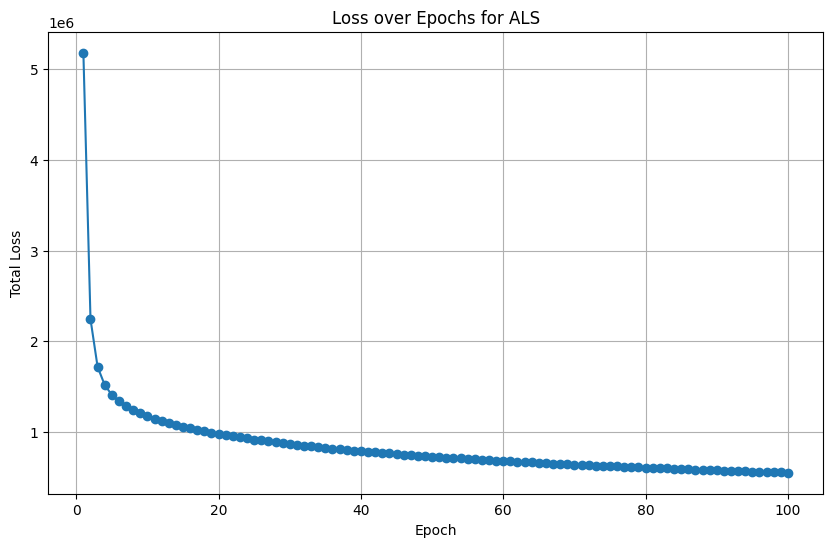

In [8]:
from matplotlib import pyplot as plt

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Loss over Epochs for ALS')
plt.grid()
plt.show()

In [9]:
def recommend_movies(user_id, M_hat, user_item_matrix, movies, top_n=10):
    """
    Recommends movies for a given user based on the predicted matrix M_hat.

    Parameters:
    - user_id: ID of the user to whom the recommendations will be made.
    - M_hat: Predicted user-item matrix (num_users x num_items).
    - user_item_matrix: Original user-item matrix (Pandas DataFrame) with ratings.
    - movies: DataFrame containing movie details (Movie_ID, Name, Year).
    - top_n: Number of recommendations to return (default is 10).

    Returns:
    - recommendations: DataFrame containing the top_n recommended movies.
    """
    # Map user_id to the corresponding index in M_hat
    user_index = user_item_matrix.index.get_loc(user_id)
    
    # Get the predicted ratings for the user
    predicted_ratings = M_hat[user_index]

    # Get the user's original ratings
    original_ratings = user_item_matrix.loc[user_id]

    # Find movies that the user has not rated (those with a rating of 0)
    unrated_movies = original_ratings[original_ratings == 0].index

    # Map the unrated movies to the correct columns in M_hat
    unrated_predictions = {
        movie_id: predicted_ratings[user_item_matrix.columns.get_loc(movie_id)]
        for movie_id in unrated_movies
    }

    # Sort the predicted ratings for unrated movies in descending order
    sorted_predictions = sorted(unrated_predictions.items(), key=lambda x: x[1], reverse=True)

    # Get the top_n movie IDs
    top_movie_ids = [movie_id for movie_id, _ in sorted_predictions[:top_n]]

    # Retrieve movie details for the top_n recommendations
    recommendations = movies[movies['Movie_ID'].isin(top_movie_ids)]

    # Create a copy of the DataFrame to avoid the SettingWithCopyWarning
    recommendations = recommendations.copy()
    
    # Add the Predicted_Rating column
    recommendations['Predicted_Rating'] = [unrated_predictions[movie_id] for movie_id in recommendations['Movie_ID']]
    
    # Sort recommendations by predicted rating (optional, for clarity)
    recommendations = recommendations.sort_values(by='Predicted_Rating', ascending=False)

    return recommendations[['Movie_ID', 'Name', 'Year', 'Predicted_Rating']]

### 4. Model Testing
The function is tested with a sample user to generate personalized recommendations.

In [10]:
# Step 4: Test the recommendation function
user_id_to_test = 774868  # Cambia con un ID utente valido nel dataset
num_recommendations = 5   # Numero di raccomandazioni desiderate

try:
    # Esegui la funzione di raccomandazione
    recommendations = recommend_movies(user_id_to_test, M_hat, user_item_matrix, movies, top_n=num_recommendations)
    
    # Mostra i risultati
    print(f"Top {num_recommendations} movie recommendations for User {user_id_to_test}:")
    print(recommendations[['Name', 'Year', 'Predicted_Rating', 'Movie_ID']])
except KeyError as e:
    print(f"Error: User ID {user_id_to_test} not found in the dataset.")
except ValueError as e:
    print(f"Error: {e}")

Top 5 movie recommendations for User 774868:
                                                Name  Year  Predicted_Rating  \
3320                                       In Dreams  1999          5.170476   
241   Neon Genesis Evangelion: The End of Evangelion  1995          3.794518   
3695                                   The Impostors  1998          3.748343   
1125   Uncovered: The Whole Truth About the Iraq War  2003          3.733851   
1654                                      Talk Radio  1988          3.482773   

      Movie_ID  
3320      3321  
241        242  
3695      3696  
1125      1126  
1654      1655  
